In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as pyplot
import time

from pandas import concat
from numpy import concatenate

from keras.models import Sequential
from keras.layers import Dense,RepeatVector
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten,TimeDistributed,RepeatVector
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import Dropout
from math import sqrt;
import tensorflow as tf


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [ ]:
url = "https://drive.google.com/file/d/1fw3DZ8DY8FBhI15vnuIijfUFSPf9hYmH/view?usp=share_link"
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url)
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [ ]:
df.shape

(145366, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [ ]:
# set attr date menjadi bertipe datetime
df['Datetime'] = pd.to_datetime(df['Datetime'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Datetime  145366 non-null  datetime64[ns]
 1   PJME_MW   145366 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.2 MB


In [ ]:
# set attr date menjadi index
df.set_index(['Datetime'],inplace=True)

# resample data over day
data = df['PJME_MW'].resample('D').sum()

In [ ]:
data=pd.DataFrame(data) # question!!!
data.head()

,PJME_MW
Datetime,
2002-01-01,714857.0
2002-01-02,822277.0
2002-01-03,828285.0
2002-01-04,809171.0
2002-01-05,729723.0


In [ ]:
data.shape

(6059, 1)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6059 entries, 2002-01-01 to 2018-08-03
Freq: D
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   PJME_MW  6059 non-null   float64
dtypes: float64(1)
memory usage: 94.7 KB


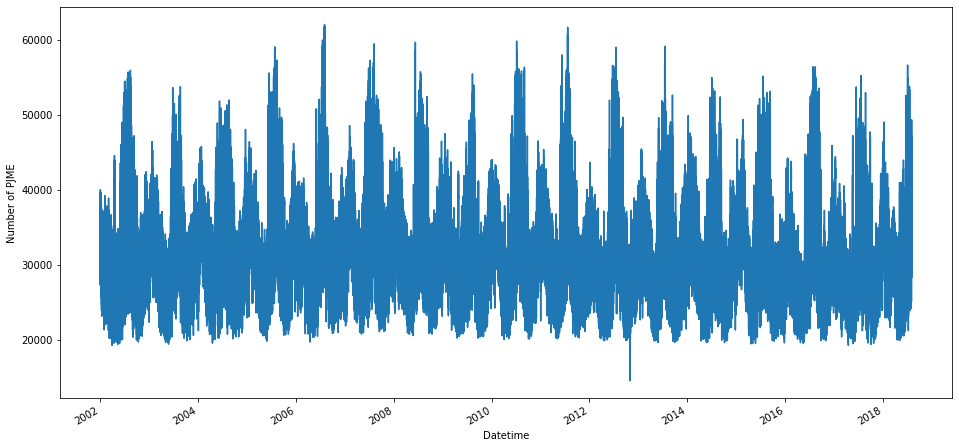

In [ ]:
pyplot.figure(figsize=(16,8))
df['PJME_MW'].plot()
pyplot.xlabel('Datetime')
pyplot.ylabel('Number of PJME')
pyplot.show()

In [ ]:
values = data.values
# values = values.astype('float32')

In [ ]:
values.shape

(6059, 1)

In [ ]:
# normalisasi
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [ ]:
#covert to time-series
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
#frame sebagai supervised learning
reframed = series_to_supervised(scaled, 1, 1)
print(reframed.head())

   var1(t-1)   var1(t)
1   0.557762  0.645954
2   0.645954  0.650886
3   0.650886  0.635194
4   0.635194  0.569967
5   0.569967  0.568360


In [ ]:
#split into train and test sets
values = reframed.values
n_train = round(reframed.shape[0]*70/100)
train = values[:n_train, :]
test = values[n_train:, :]
#split into input and outputs
train_X, train_y = train[:, :1], train[:, 1]
test_X, test_y = test[:, :1], test[:, 1]

In [ ]:
#reshap input menjadi 3D ([)samples, timesteps, features)
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(4241, 1, 1) (4241,) (1817, 1, 1) (1817,)


In [ ]:
#design network CNN
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))

model.add(MaxPool1D(pool_size=1))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1,activation='relu'))

model.compile(loss='mse', optimizer='adam')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 1, 64)             128       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 1, 64)             0         
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                      

In [ ]:
#fit network
start = time.time()
history = model.fit(train_X, train_y, epochs=100, batch_size=128, validation_data=(test_X, test_y), verbose=1, shuffle=False)
end = time.time()
print('Processing Time {} seconds.'.format(end-start))

Epoch 1/100
34/34 [==============================] - 1s 9ms/step - loss: 0.1536 - val_loss: 0.0103
Epoch 2/100
34/34 [==============================] - 0s 5ms/step - loss: 0.0184 - val_loss: 0.0040
Epoch 3/100
34/34 [==============================] - 0s 5ms/step - loss: 0.0135 - val_loss: 0.0060
Epoch 4/100
34/34 [==============================] - 0s 4ms/step - loss: 0.0118 - val_loss: 0.0049
Epoch 5/100
34/34 [==============================] - 0s 4ms/step - loss: 0.0106 - val_loss: 0.0053
Epoch 6/100
34/34 [==============================] - 0s 4ms/step - loss: 0.0098 - val_loss: 0.0048
Epoch 7/100
34/34 [==============================] - 0s 5ms/step - loss: 0.0088 - val_loss: 0.0055
Epoch 8/100
34/34 [==============================] - 0s 5ms/step - loss: 0.0082 - val_loss: 0.0045
Epoch 9/100
34/34 [==============================] - 0s 5ms/step - loss: 0.0080 - val_loss: 0.0050
Epoch 10/100
34/34 [==============================] - 0s 4ms/step - loss: 0.0074 - val_loss: 0.0055
Epoch 11/

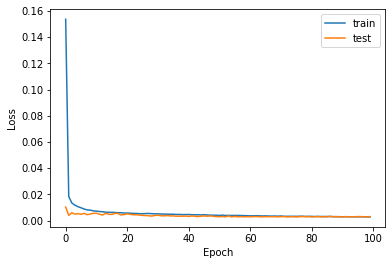

In [ ]:
#plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.xlabel('Epoch')
pyplot.ylabel('Loss')
pyplot.legend()
pyplot.show()

In [ ]:
#membuat prediksi training
xhat = model.predict(train_X)
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))

#invert scaling untuk peramalan
inv_xhat = concatenate((xhat, train_X[:, 1:]), axis=1)
inv_xhat = scaler.inverse_transform(inv_xhat)
inv_xhat = inv_xhat[:,0]

#invert scaling untuk aktual
train_y = train_y.reshape((len(train_y), 1))
inv_x = concatenate((train_y, train_X[:, 1:]), axis=1)
inv_x = scaler.inverse_transform(inv_x)
inv_x = inv_x[:,0]

#================================================================#

#membuat prediksi testing
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

#invert scaling untuk peramalan
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

#invert scaling untuk aktual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

57/57 [==============================] - 0s 2ms/step


In [ ]:
# calculate RMSE
rmsetrain = np.sqrt(mean_squared_error(xhat, train_y))
print(f'RMSE Training is : %.3f' % rmsetrain)
# rmsetrain = np.sqrt(mean_squared_error(inv_x, inv_xhat))
# print(f'RMSE Training is : %.3f' % rmsetrain)

rmsetest = np.sqrt(mean_squared_error(test_y, yhat))
print(f'RMSE Testing is : %.3f' % rmsetest)
# rmsetest = np.sqrt(mean_squared_error(inv_y, inv_yhat))
# print(f'RMSE Testing is : %.3f' % rmsetest)


def mean_absolute_percentage_error(yhat, test_y):
    yhat, test_y = np.array(yhat), np.array(test_y)
    return np.mean(np.abs((yhat, test_y) / test_y))

print(f'MAPE train is : {(mean_absolute_percentage_error(train_y, xhat))}')
# print(f'MAPE train is : {(mean_absolute_percentage_error(inv_x, inv_xhat))}')

print(f'MAPE test is : {(mean_absolute_percentage_error(test_y, yhat))}')
# print(f'MAPE test is : {(mean_absolute_percentage_error(inv_y, inv_yhat))}')

print(f'R2 train is : {r2_score(train_y, xhat)}')
# print(f'R2 train is : {r2_score(inv_x, inv_xhat)}')

print(f'R2 test is : {r2_score(test_y, yhat)}')
# print(f'R2 test is : {r2_score(inv_y, inv_yhat)}')

mse = (mean_squared_error(inv_y, inv_yhat))
print('Test MSE: %.2f' % mse)
# print('Test MSE: %.2f' % (mean_squared_error(train_y, yhat)))

RMSE Training is : 0.053
RMSE Testing is : 0.055
MAPE train is : 1.0140419034912798
MAPE test is : 1.0059582856103042
R2 train is : 0.6709236934696836
R2 test is : 0.6505305373905219
Test MSE: 4508434128.94


In [ ]:
yhat.shape

(1817, 1)

Actual : [878332. 747884. 720115. ... 941539. 950233.  35486.]
Predicted: [833379.68623614 825360.19052064 729180.25651729 ... 788583.30197072
 873139.06547046 879735.66897488]


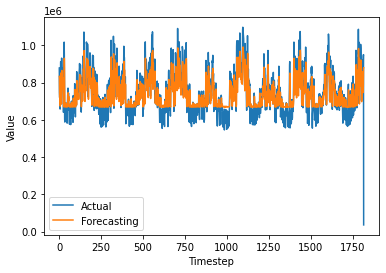

In [ ]:
print('Actual :', inv_y)
print('Predicted:', inv_yhat)
# plot history
pyplot.plot(inv_y, label='Actual')
pyplot.plot(inv_yhat, label='Forecasting')
pyplot.xlabel('Timestep')
pyplot.ylabel('Value')
pyplot.legend()
pyplot.show()